### Compare lead area fraction for nextsim and Arcleads product (MODIS)

#### Author: Jonathan Rheinlænder*
#### Date: Jun. 02 2022
#### Affiliation: Nansen Environmental and Remote Sensing Center, Bergen, Norway

In [1]:
%matplotlib inline
import numpy as np
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr
import matplotlib.colors as colors
import scipy.stats
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpec
from eval_metrics import *
import calc_leadfrac as clf


In [2]:
# load data 

# setup directories 
rootdir = '/home/rheinlender/shared-simstore-ns9829k/'
outpath_plots =  rootdir + 'home/rheinlender/figs/breakup-paper/'
inpath = rootdir + 'home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/'

# open Arcleads interpolated to nextsim grid
arc = xr.open_dataset(rootdir + '/home/rheinlender/data/Arcleads/Arcleads_interp2nextsim_20130212-20130313.nc')

# Open neXtSIM data
expts = ["expt_01_wrf10/outputs/"]
fl = inpath + expts[0] + 'Moorings.nc'
print("loading", fl)

mooring = xr.open_dataset(fl) # load data
nlon = mooring.longitude.values
nlat = mooring.latitude.values
time = mooring['time'].time.values.astype('datetime64[ms]').astype('O')

loading /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/expt_01_wrf10/outputs/Moorings.nc


In [4]:
# subset region: Beaufort Sea
x0=0; x1=260
y0=150; y1=410

bbox = (x0,x1,y0,y1)

# calculate MODIS lead area fraction
MODIS_laf = clf.calc_leadAreaFrac_MODIS(arc, bbox)

# calculate nextsim lead area fraction
nc_laf, nlead = clf.calc_leadAreaFrac_nextsim(mooring, 0.05, bbox)
nc_laf003, nlead003 = clf.calc_leadAreaFrac_nextsim(mooring, 0.03, bbox)
nc_laf007, nlead007 = clf.calc_leadAreaFrac_nextsim(mooring, 0.07, bbox)

# convert to %
nc_laf = nc_laf*100
nc_laf003 = nc_laf003*100
nc_laf007 = nc_laf007*100
MODIS_laf = MODIS_laf*100

MODIS_laf = MODIS_laf[1:-1]
MODIS_time = MODIS_laf['time'].time.values.astype('datetime64[ms]').astype('O')

# Calculate R value
nc_lafdaily = nc_laf.resample(time='1D').mean()
pearson_r, pearson_p = scipy.stats.pearsonr(nc_lafdaily, MODIS_laf)    # Pearson's r

pearson_r =round(pearson_r,2)


# Plot timeseries of lead area fraction for nextsim and Arcleads 

saving  /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/figs/breakup-paper/leadfraction_BeaufortSea_nextsim+MODIS.png


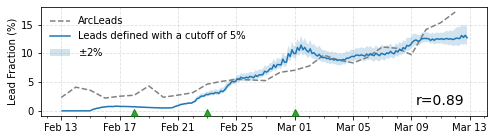

In [5]:
fig, ax = plt.subplots(figsize=(8,2),ncols=1)

ax.plot(MODIS_time, MODIS_laf, ls='--', color='grey', lw='1.5')
ax.plot(time, nc_laf)
ax.fill_between(time, nc_laf003, nc_laf007, alpha=0.2)

name = ['ArcLeads', 'Leads defined with a cutoff of 5%', '$\pm$2%']
ax.legend(name, loc='upper left', frameon=False)# add legend 

# add vertical lines to mark dates
datestr = ('2013-02-18', '2013-02-23', '2013-03-01')
cbargs = {'color': 'green', 'alpha': 0.5, 'zorder':3, 'marker':"^", 'markersize': 15, 'ymax':0.}
[plt.axvline(dt.datetime.strptime(dto,'%Y-%m-%d'), **cbargs) for dto in datestr]

ax.set_ylabel("Lead Fraction (%)")
ax.grid(zorder=2, linestyle='--', alpha=0.4)
days = mdates.DayLocator()  # every day
dtFmt = mdates.DateFormatter('%b %d') # define the formatting 
ax.xaxis.set_major_formatter(dtFmt)
ax.xaxis.set_minor_locator(days)

ax.yaxis.set_ticks([0, 5, 10, 15])

plt.text(0.84, 0.1, f'r={pearson_r}', size=14, transform=ax.transAxes)

# save figure
figname = outpath_plots+'leadfraction_BeaufortSea_nextsim+MODIS.png'
print("saving ", figname)
fig.savefig(figname, dpi=300)   

# Histograms of the leadfraction in the Beaufort Sea on March 1 2013
Check the sensitivity of choosing a different cut-off value

In [5]:
dto = "2013-03-01"

leadfrac = clf.get_leadfraction_nextsim(mooring)
leadmap005 = clf.leadmap_nextsim(mooring, 0.05) # Using 5% (default) 
leadmap003 = clf.leadmap_nextsim(mooring, 0.03) # Using 3%
leadmap007 = clf.leadmap_nextsim(mooring, 0.07) # Using 7%

leadfrac = leadfrac.sel(x=slice(x0,x1), y=slice(y0,y1), time=dto)[-1]
leadmap005 = leadmap005.sel(x=slice(x0,x1), y=slice(y0,y1), time=dto)[-1]
leadmap003 = leadmap003.sel(x=slice(x0,x1), y=slice(y0,y1), time=dto)[-1]
leadmap007 = leadmap007.sel(x=slice(x0,x1), y=slice(y0,y1), time=dto)[-1]

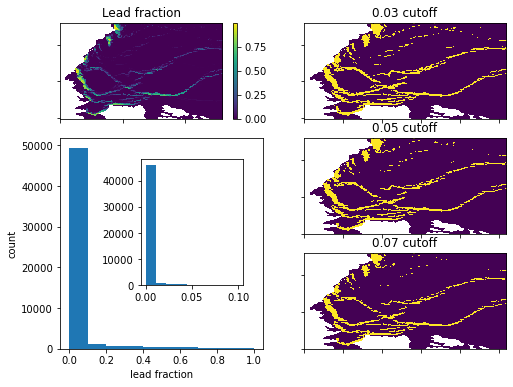

In [6]:
fig = plt.figure(figsize=(8, 6))
gs = GridSpec(nrows=3, ncols=2)

ax0 = fig.add_subplot(gs[0, 0])
leadfrac.plot.imshow(ax=ax0)

ax1 = fig.add_subplot(gs[1:, 0])
leadfrac.plot.hist(ax=ax1)
ax1.set_title('')

ax2 = fig.add_subplot(gs[0, 1])
leadmap003.plot.imshow(ax=ax2, add_colorbar=False)

ax3 = fig.add_subplot(gs[1, 1])
leadmap005.plot.imshow(ax=ax3, add_colorbar=False)

ax4 = fig.add_subplot(gs[2, 1])
leadmap007.plot.imshow(ax=ax4, add_colorbar=False)

# add inset axis (zoom in)
axin1 = ax1.inset_axes([0.4, 0.3, 0.5, 0.6])
bins = np.linspace(0,0.1,10)   
leadfrac.plot.hist(ax=axin1, bins=bins)
axin1.set_title('')

ax0.set_title('Lead fraction')
ax2.set_title('0.03 cutoff')
ax3.set_title('0.05 cutoff')
ax4.set_title('0.07 cutoff')
ax1.set_xlabel('lead fraction')
ax1.set_ylabel('count')


for ax in [ax0, ax2, ax3, ax4]:
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_xlabel('')
    ax.set_ylabel('')